## PART ONE : WEEKENDS SALES TRENDS 

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

Since some stores (probably) were closed on Fridays, we should deal with them because they can invalidate the analysis and clustering output. We have several approaches to handle this problem:

1. Remove 0 sales from the data:** This approach involves removing rows with zero sales on Fridays. It's a straightforward method but may result in a loss of data for some stores.

2. Replace 0 sales with the mean sales of two consecutive Fridays with sales:** In this approach, we calculate the mean sales of two consecutive Fridays with sales for each store and replace zero sales with this mean value. This method helps retain data for all stores but assumes sales follow a consistent pattern between consecutive Fridays.

3. Replace 0 sales with the nearest sales to that day:** Here, we find the nearest non-zero sales data point for the days with zero sales and replace them with the nearest sales value. This method attempts to capture the variation in sales more accurately for each store.

Each of these approaches has its advantages and drawbacks, and the choice depends on the specific goals of our analysis and the assumptions we are willing to make. 
## After glancing on our data and the concepts of the analysis we decided to continue with the third given option.


In [91]:
data = pd.read_csv('DataScientistChallengeData.csv')

## Replacing Zero values with the nearest values backward; Therefore Fridays zero values will be replaced with Thursdays which is still count as a weekend

In [92]:
data["Sales"].replace(0, np.nan, inplace=True)
data["Sales"] = data["Sales"].interpolate(method="nearest")

In [93]:
data['Date'] = pd.to_datetime(data['Date'])

## Extracting weekdays based on dates

In [94]:
data['DayOfWeek'] = data['Date'].dt.dayofweek
data.head()

,StoreID,Date,Sales,DayOfWeek
0,1,2020-07-01,29559.916214,2
1,1,2020-07-02,36765.847944,3
2,1,2020-07-03,31261.577192,4
3,1,2020-07-04,26516.164081,5
4,1,2020-07-05,31614.797517,6


In [95]:
day_of_week_mapping = {
    5: 'Saturday',
    6: 'Sunday',
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday'
}

In [96]:
data['DayOfWeek'] = data['DayOfWeek'].map(day_of_week_mapping)
data.head()

,StoreID,Date,Sales,DayOfWeek
0,1,2020-07-01,29559.916214,Wednesday
1,1,2020-07-02,36765.847944,Thursday
2,1,2020-07-03,31261.577192,Friday
3,1,2020-07-04,26516.164081,Saturday
4,1,2020-07-05,31614.797517,Sunday


## Plotting average sales by day to see day to day sales trend

In [97]:
sales_by_day = data.groupby('DayOfWeek')['Sales'].mean().reindex(day_of_week_mapping.values())
sales_by_day

DayOfWeek
Saturday     58507.455694
Sunday       61592.050232
Monday       61411.209999
Tuesday      61688.942587
Wednesday    65597.583094
Thursday     87170.553237
Friday       98362.668693
Name: Sales, dtype: float64

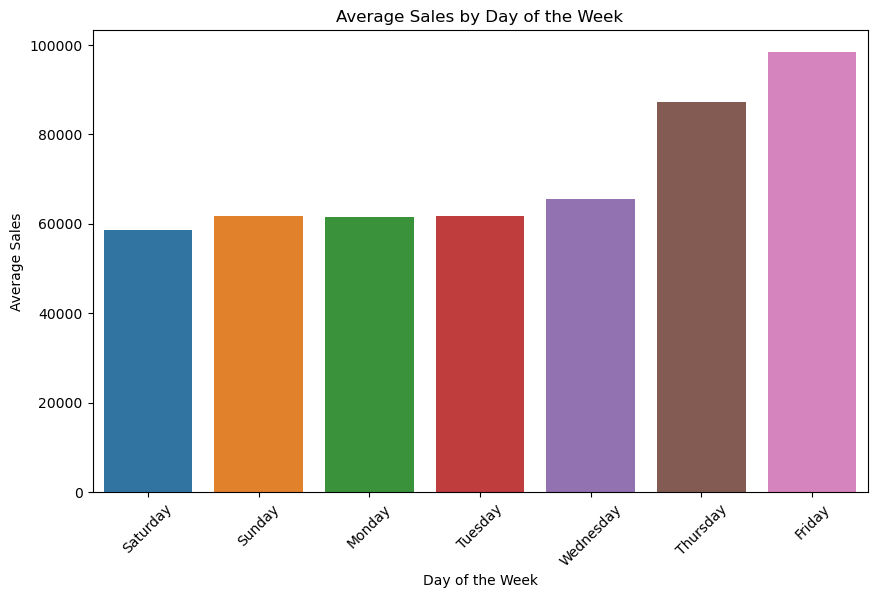

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

## Thursdays and Fridays have the most sales , indicate the raise of sales in many stores due to the weekends in the country
As I knew, since Mondays is a promotion day at Hyperstar Markets I was expecting more sales in this day

In [99]:
friday_data = data[data['DayOfWeek'] == 'Friday']
friday_sales_growth = (friday_data['Sales'] - friday_data['Sales'].shift(1)) / friday_data['Sales'].shift(1)

In [100]:
data['FridaySalesGrowth'] = friday_sales_growth
data.head(n=17)

,StoreID,Date,Sales,DayOfWeek,FridaySalesGrowth
0,1,2020-07-01,29559.916214,Wednesday,NaN
1,1,2020-07-02,36765.847944,Thursday,NaN
2,1,2020-07-03,31261.577192,Friday,NaN
3,1,2020-07-04,26516.164081,Saturday,NaN
4,1,2020-07-05,31614.797517,Sunday,NaN
5,1,2020-07-06,27622.129946,Monday,NaN
6,1,2020-07-07,27456.194337,Tuesday,NaN
7,1,2020-07-08,26892.755237,Wednesday,NaN
8,1,2020-07-09,35163.297130,Thursday,NaN
9,1,2020-07-10,30892.544220,Friday,-0.011805


## Finding the Store with the most sales growth on Fridays

In [101]:
best_store = data[data['DayOfWeek'] == 'Friday'].groupby('StoreID')['FridaySalesGrowth'].mean().idxmax()

print(f"The store with the highest average sales growth on Fridays is StoreID {best_store}")

The store with the highest average sales growth on Fridays is StoreID 7


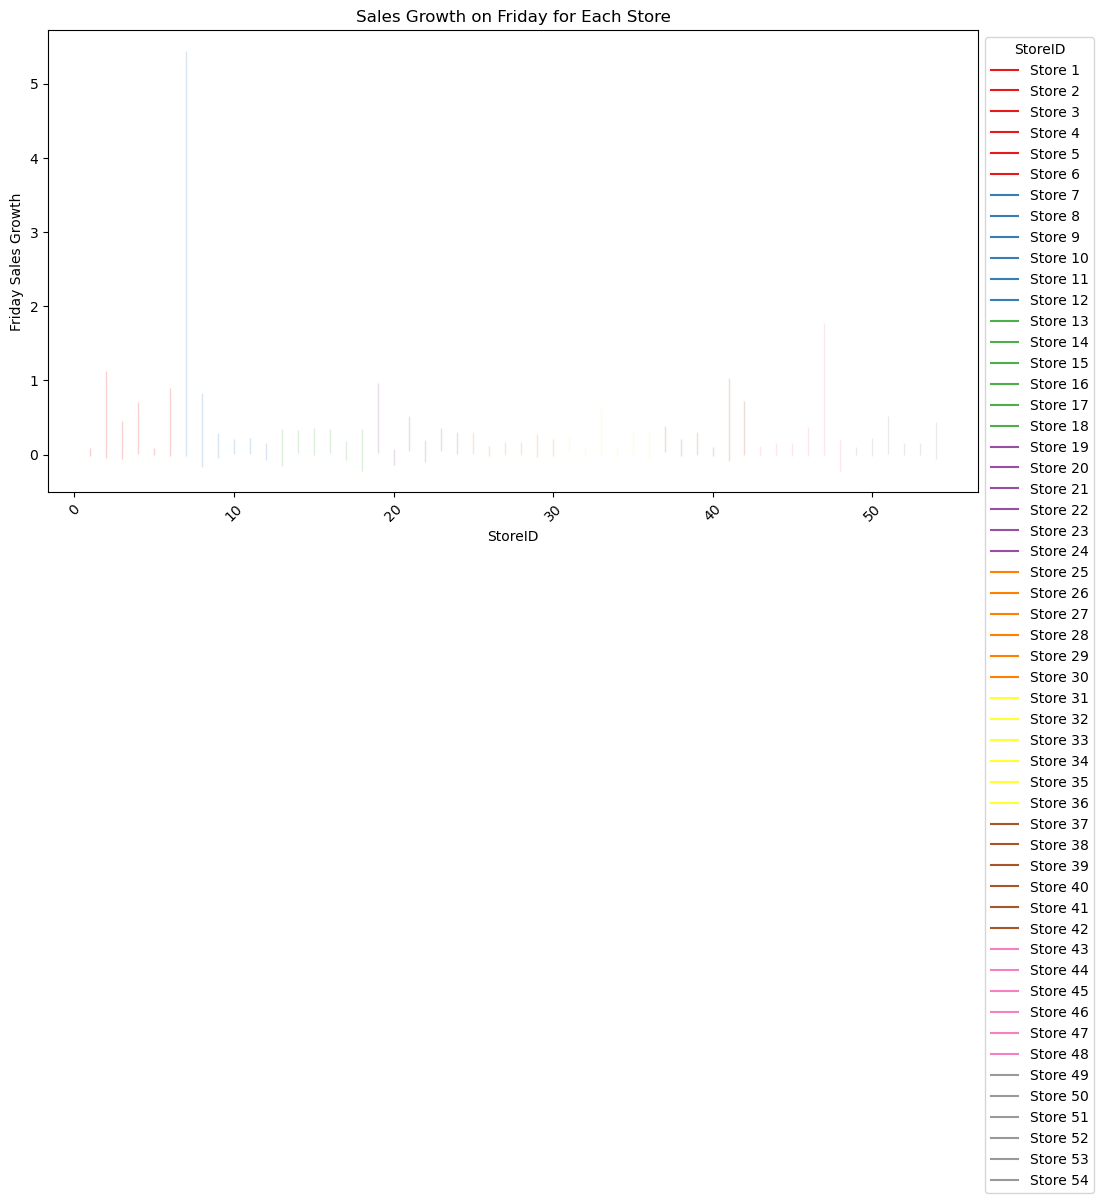

In [102]:
friday_data = data[data['DayOfWeek'] == 'Friday']
store_ids = friday_data['StoreID'].unique()

cmap = plt.get_cmap('Set1', len(store_ids))

plt.figure(figsize=(12, 6))

for i, store_id in enumerate(store_ids):
    store_data = friday_data[friday_data['StoreID'] == store_id]
    sns.lineplot(data=store_data, x='StoreID', y='FridaySalesGrowth', color=cmap(i), label=f'Store {store_id}')

plt.title('Sales Growth on Friday for Each Store')
plt.xlabel('StoreID')
plt.ylabel('Friday Sales Growth')
plt.xticks(rotation=45)
plt.legend(title='StoreID', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## PART TWO: CLUSTERING

First we find growth rate per store then choose *StoreID*, *Sales*, and *GrowthRate* as our features to fit and cluster stores based on them 

In [52]:
data['GrowthRate'] = (data['Sales']-data['Sales'].shift(1)) / data['Sales'].shift(1)
store_1_mean_growth_rate = data[data["StoreID"] == 1]["GrowthRate"].mean()
data["GrowthRate"].fillna(store_1_mean_growth_rate, inplace=True)

## Aggregating standardscaled sales and growth rate per store

as we have 54 stores and each has many rows with different values in our data, to have a robust clustering machine, we aggregate per store data as ONE.
To do that, we standard scale sales and growth rate per store

In [68]:
clustering_df = pd.DataFrame(columns=["StoreID", "Sales", "GrowthRate"])
data = data[['StoreID', 'Sales','GrowthRate']]

for s_id in set(data["StoreID"]):
    slice_df = data[data["StoreID"] == s_id]
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(slice_df)
    mean_sales_scaled = np.mean([s[1] for s in scaled_values])
    mean_growth_scaled = np.mean([s[2] for s in scaled_values])
    clustering_df = pd.concat([clustering_df, pd.DataFrame([{"StoreID": s_id, "Sales": mean_sales_scaled, "GrowthRate": mean_growth_scaled}])], ignore_index=True)

print(clustering_df)

   StoreID         Sales    GrowthRate
0        1  3.888059e-17  0.000000e+00
1        2 -1.854830e-16 -7.133963e-18
2        3 -2.275760e-16  1.264311e-17
3        4 -4.276865e-16 -7.290110e-18
4        5  1.555223e-16 -2.673040e-17
5        6 -1.490649e-16 -2.173863e-17
6        7 -4.890850e-17 -2.347608e-17
7        8  5.224579e-17 -2.285753e-17
8        9 -4.695216e-17 -9.781701e-18
9       10 -7.776117e-17  0.000000e+00
10      11  1.944029e-16  1.093517e-17
11      12  1.389001e-16  5.477752e-17
12      13  1.306145e-16  2.612289e-17
13      14  1.166418e-16  5.589084e-17
14      15  7.776117e-17 -2.916044e-17
15      16 -3.888059e-17  1.215018e-17
16      17 -2.347608e-17 -1.173804e-17
17      18  4.672697e-16 -6.100127e-18
18      19 -3.888059e-17  2.794542e-17
19      20  2.952721e-16  7.086530e-18
20      21 -9.720147e-17 -1.944029e-17
21      22  1.122423e-16 -1.220025e-17
22      23  9.733462e-17  7.300097e-18
23      24 -5.393114e-17 -3.370696e-18
24      25 -9.720147e-17 

In [69]:
X = clustering_df
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Finding The best Cluster number Using Elbow method

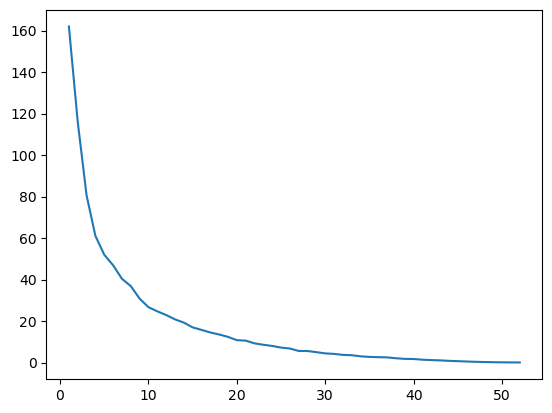

In [70]:
elbow = list()
for i in range(1, 53):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    elbow.append(kmeans.inertia_)

plt.plot(range(1, 53), elbow)
plt.show()

In [73]:
kmeans = KMeans(n_clusters=9, random_state=42)
clustering_df['Cluster'] = kmeans.fit_predict(X_scaled)
clustering_df

,StoreID,Sales,GrowthRate,Cluster
0,1,3.888059e-17,0.000000e+00,6
1,2,-1.854830e-16,-7.133963e-18,6
2,3,-2.275760e-16,1.264311e-17,6
3,4,-4.276865e-16,-7.290110e-18,6
4,5,1.555223e-16,-2.673040e-17,0
5,6,-1.490649e-16,-2.173863e-17,6
6,7,-4.890850e-17,-2.347608e-17,0
7,8,5.224579e-17,-2.285753e-17,0
8,9,-4.695216e-17,-9.781701e-18,6
9,10,-7.776117e-17,0.000000e+00,6


##  Ploting the Clusters to evaluate the efficency of our clustering 

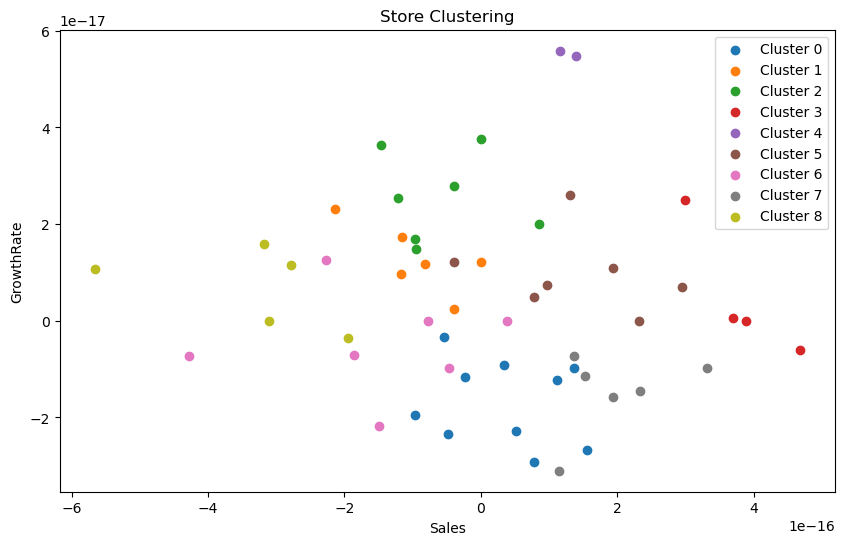

In [83]:
plt.figure(figsize=(10, 6))
for cluster in range(9):
    cluster_data = clustering_df[clustering_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Sales'], cluster_data['GrowthRate'], label=f'Cluster {cluster}')

plt.title('Store Clustering')
plt.xlabel('Sales')
plt.ylabel('GrowthRate')
plt.legend()
plt.show()

## Here is the Stores with the same sales behavior 

In [84]:
print(clustering_df[["Cluster", "StoreID"]].sort_values(by="Cluster").to_string(index=False))

 Cluster StoreID
       0      21
       0      24
       0      17
       0      15
       0       5
       0      26
       0       7
       0       8
       0      22
       0      30
       1      53
       1      54
       1      43
       1      45
       1      47
       1      49
       2      34
       2      25
       2      31
       2      38
       2      37
       2      19
       2      35
       3      40
       3      41
       3      42
       3      18
       4      14
       4      12
       5      23
       5      16
       5      13
       5      29
       5      11
       5      33
       5      20
       6       1
       6      10
       6       9
       6       6
       6       4
       6       3
       6       2
       7      46
       7      39
       7      52
       7      44
       7      51
       7      50
       8      32
       8      36
       8      28
       8      48
       8      27
